# Introduction

In the previous three lessons, you learned several fundamental time series concepts like stationarity and smoothing. Now we'll build upon that knowledge by digging into yet another important concept called **autocorrelation**.

# Learning Outcomes
You should walk away from this tutorial with:
1. A practical understanding of Moving Average (MA) models.
2. A basic understanding of the Autocorrelation Function (ACF).
3. Insight into choosing the order *q* of MA models.
4. A practical understanding of Autoregressive (AR) models.
5. A basic understanding of the Partial Autocorrelation Function (PACF).
6. Insight into choosing the order *p* of AR models.

# Imports

In [1]:
%matplotlib inline

import sys
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Python & Library Versions

In [2]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("statsmodels", ss.__version__) )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

('2.7.15 |Anaconda, Inc.| (default, May  1 2018, 18:37:05) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]', '\n')
library    version
------------------
matplotlib  2.2.2
numpy       1.14.3
pandas      0.23.0
statsmodels 0.9.0


---

# Section 1: Moving Average (MA) & MA Models 

In this lesson, we will revisit moving average smoothing and explore the idea of moving average models. Please be aware that these two concepts are not equivalent. Each serves a different, important function.

### What is a Moving Average?
Moving average is perhaps one of the most obvious and simplest techniques you can use to capture local changes in time series data as well as provide forecasts. In fact, we explored MA in some detail last lesson. We discussed simple and exponential smoothing. We also discussed single, double, and triple exponential smoothing. If you're fuzzy about any of those terms, please go back and review now. 

Let's build upon this knowledge by going a bit deeper. 

Recall that the forecast value $\hat{y}_{t+1} = \frac{y_t + y_{t-1} + ... + y_{t-m+1}}{m}$

It's worth pondering that formula for a minute. While easy to understand, one of its properties may not be obvious. What's the lag associated with this technique? Think it through. 

The answer is $\frac{(m+1)}{2}$. For example, say you're averaging the past 5 values to make the next prediction. Then local changes will yield a lag of $\frac{5+1}{2} = 3$ periods. Clearly, the lag increases as you increase the the window size for averaging. 

You may think to yourself, "Well, I'll just use a small window size." Doing so will create a more responsive model. However, a window size that's too small will chase noise in the data as opposed to extracting the pattern. As with most things in machine learning, there is a tradeoff between the two. The best answer lies somewhere between and requires careful tuning to determine which setup is best for a given dataset. 

Let's generate some toy data and apply a moving average with different window sizes to see that what we discussed is in fact true. 

In [3]:
# reproducibility
np.random.seed(42)

# time component
time = np.arange(100)

# data
noise = np.random.normal(loc=0, scale=6.5, size=len(time))
trend = time * 2.75
seasonality = 10 + np.sin(time * 0.25) * 20
data = trend + seasonality + noise

Yet another friendly reminder that you should always visually inspect your time series with a run-sequence plot. 
> We'll leverage the *run_sequence_plot* function to make plotting throughout this tutorial less cumbersome.

In [4]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-', label="actual")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.legend();

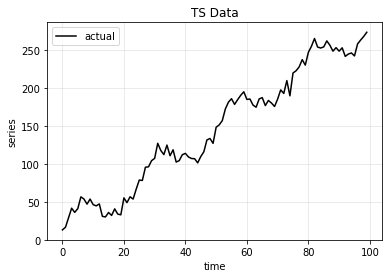

In [5]:
run_sequence_plot(time, data, title="TS Data")

Great, now we need a moving average function. Thankfully, pandas has a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html) function we can leverage.

We'll try three window sizes: 3, 5, 9. Then we'll plot the results.

In [6]:
series = pd.Series(data)

# case with lag of 2
lag_2 = series.rolling(window=3).mean()

# case with lag of 3
lag_3 = series.rolling(window=5).mean()

# case with lag of 5
lag_5 = series.rolling(window=9).mean()

# case with lag of 10
lag_10 = series.rolling(window=19).mean()

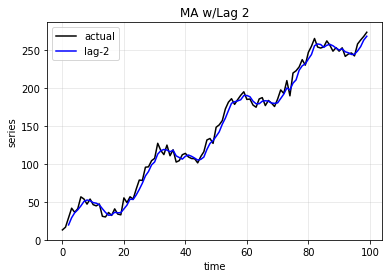

In [7]:
run_sequence_plot(time, data, title="MA w/Lag 2")
plt.plot(time, lag_2, 'b-', label="lag-2")
plt.legend();

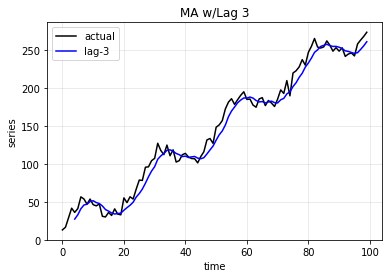

In [8]:
run_sequence_plot(time, data, title="MA w/Lag 3")
plt.plot(time, lag_3, 'b-', label="lag-3")
plt.legend();

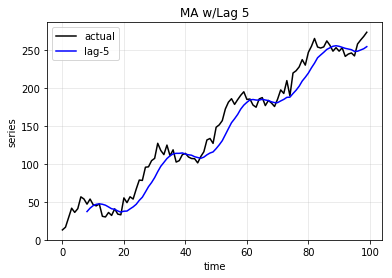

In [9]:
run_sequence_plot(time, data, title="MA w/Lag 5")
plt.plot(time, lag_5, 'b-', label="lag-5")
plt.legend();

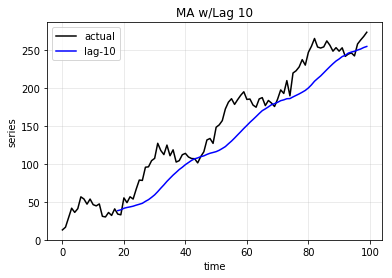

In [10]:
run_sequence_plot(time, data, title="MA w/Lag 10")
plt.plot(time, lag_10, 'b-', label="lag-10")
plt.legend();

The tradeoff is responsiveness versus smoothing capabilities. Let's make this clearer by plotting the three moving average curves sans actual data.

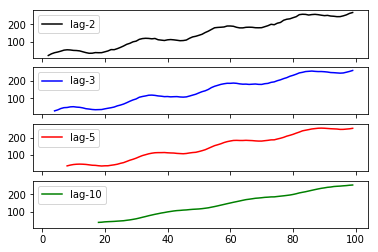

In [11]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True)
axes[0].plot(time, lag_2, 'k-', label="lag-2")
axes[0].legend()
axes[1].plot(time, lag_3, 'b-', label="lag-3")
axes[1].legend()
axes[2].plot(time, lag_5, 'r-', label="lag-5")
axes[2].legend()
axes[3].plot(time, lag_10, 'g-', label="lag-10")
axes[3].legend();

### MA Models != Moving Average Smoothing
An important distinction is that a moving average model is not the same thing as moving average smoothing. What we did above was smoothing. It has important properties already discussed. However, we turn our attention to moving average models, which are a completely different beast.

Moving average smoothing is useful for estimating trend and seasonality of past data. MA models, on the other hand, are a useful forecasting model that regresses on past forecast errors in order to forecast future values. It is easy to lump the two techniques together, but they serve very different functions. 

### MA Model Specifics
A MA model is defined by this equation: $y_t=c+e_t+θ_1e_{t−1}+θ_2e_{t−2}+⋯+θ_qe_{t−q}$ where $e_t$ is white noise. The value $c$ is a constant value and the $\theta$'s are coefficients, not unlike those found in linear regression.

Fitting a MA models is quite involved and requires iterative procedures. The details are beyond the scope of this lesson. However, statsmodels has this functionality built in so we can build a model with minimal effort. Let's take a look.

### MA Models with Statsmodels

In [12]:
from statsmodels.tsa.arima_model import ARMA

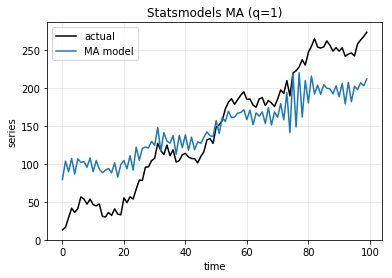

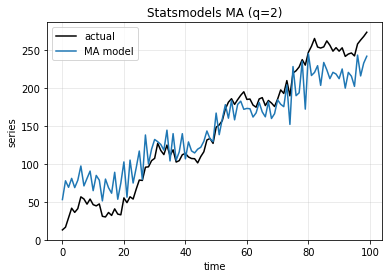

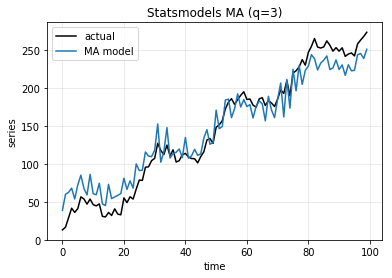

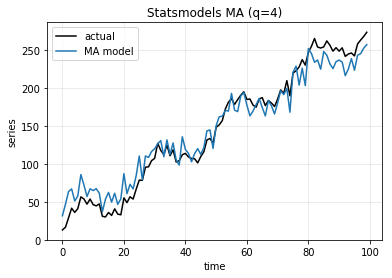

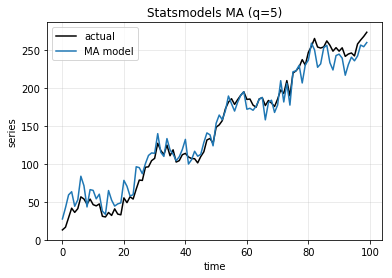

In [13]:
# plot different orders (q's)
for i in range(1,6):
    model = ARMA(data, (0,i)).fit()
    run_sequence_plot(time, data, title="Statsmodels MA (q={})".format(i))
    plt.plot(time, model.predict(start=1, end=100), label="MA model")
    plt.legend()
    plt.show();

Now that we understand the basics of MA models, let's turn our attention to selecting the proper order called *q*.

---

# Section 2: The Autocorrelation Function (ACF)
There's a crucial question we need to answer: How do you choose the order, known as *q*, of the MA model?

In order to answer that question, we need to understand the Autocorrelation Function (ACF). 

Let's start by showing an example ACF plot for our dataset called *data*.

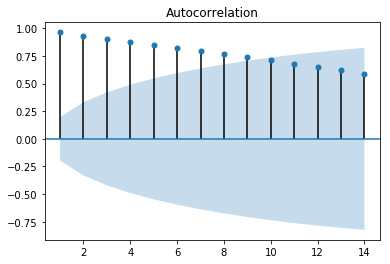

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

fig = plot_acf(data, lags=range(1,15), alpha=0.05)

An explanation is in order. First, the blue region represents a confidence interval. Alpha in this case was set to 0.05 (95% confidence interval). This can be set to whatever float value you require. See the **plot_acf** function for details. 

The stems represent lagged correlation values. In other words, a lag of 1 correlates almost perfectly with the current endogenous value. A lag of 2 correlates nearly but not quite as well. And so on. Remember that we're regressing on past forecast errors; that's the correlation we're inspecting here. 

Correlations outside of the confidence interval are statistically significant whereas the others are not. You can use this plot to choose the value of *q* to include in your MA model. One key thing to note is that **MA models require stationarity**. You should see correlations drop quickly. If they don't, that's a sign that your data is not stationary, as we see here.

In the interest of rigor, we'll test our data with the Augmented Dickey-Fuller test, though we know how this particular data was generated (i.e. it has trend and seasonality). Therefore, it is not stationary. We can, however, transform it by applying a difference and checking for stationarity once again.

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data)
print(pvalue)

A p-value that high means we must fail to reject the null that this data is nonstationary - as we knew all along. Now let's apply three differences and check again.

In [ ]:
difference = data[:-1] - data[1:]
difference2 = difference[:-1] - difference[1:]

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(difference2)
print(pvalue)

We're stationary now!

In [ ]:
run_sequence_plot(time[2:], difference2, title="Stationary Data")

In [ ]:
fig = plot_acf(difference2, lags=range(1,15), alpha=0.05)

The plot above shows AR(1) is most appropriate.
> See [here](https://people.duke.edu/~rnau/411arim2.htm) for an in-depth explanation.

That concludes our discussion of MA models. Let's now turn our attention to AR models.

---

# Section 3: Autoregressive (AR) Models
In this lesson, we will explore the idea of autoregressive models and how to determine the proper order with the Partial Autocorrelation Function (PACF). 

### What is an Autoregressive Model?
AR models are similar to MA models with one key distinction. MA models regress on past forecast errors in order to forecast future values. On the other hand, AR models regress on actual past values, not past errors. 

This is the first order or **AR(1)** formula you should know: $y_t = \beta_0 + \beta_1y_{t-1}+\epsilon_t$

The $\beta$'s are just like those in linear regression and $\epsilon$ is irreducible error.

A second order or **AR(2)** would look like this: $y_t = \beta_0 + \beta_1y_{t-1}+\beta_2y_{t-2}+\epsilon_t$

The pattern of adding another coefficient and another past term continues to whichever order you choose. Choosing that order called *p* is something we will discuss shortly.

In the meantime, let's walk through a basic autocorrelation example. We'll generate our own data so we know the generative process.

In [ ]:
# seed to start series
seed = 14

# reproducibility
np.random.seed(123)

# create autocorrelated data
lagged = np.empty_like(time, dtype='float')
for t in time:
    lagged[t] = seed + np.random.normal(loc=0, scale=2.5, size=1)
    seed = lagged[t]
    if t > 0:
        lagged[t] = lagged[t] + (0.7 * lagged[t-1])

In [ ]:
run_sequence_plot(time, lagged, title="Autocorrelated Data");

In [ ]:
# plot different orders (q's)
for i in range(1,6):
    model = ARMA(data, (i,0)).fit()
    run_sequence_plot(time, data, title="Statsmodels AR (p={})".format(i))
    plt.plot(time, model.predict(start=1, end=100), label="AR model")
    plt.legend()
    plt.show();

---

# Section 4: The Partial Autocorrelation Function (PACF)


Choosing the order *p* of the AR model is important. Thankfully, there's a useful plot called the Partial Autocorrelation Function plot that can help us with that task. 

Let's look at an example.

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_pacf(data, lags=range(1,15), alpha=0.05)

This plot is quite easy to read. First off, the blue region once again is the 95% confidence interval. The ACF is a way to measure the linear relationship between a current observation and observations at previous time periods. It turns out we are really only interested in the relationship between the current observation and a past value determined by a lag value. We often don't care about the relationship of values between the two, so we transform them to obtain the PACF. The key takeaway is the PACF is a useful tool for identifying the order of the AR model.

This example shows that an AR(1) model is most appropriate for this data. We know this because the partial autocorrelation is significant for this lag but for no other lags.

---

# Exercise #4
You have been provided two datasets: 
1. **auto_1.npy**
2. **auto_2.npy**

Your task is to leverage what you've learned in this and previous courses. 

More specifically, you will do the following:
1. Read in **auto_1.npy** and **auto_2.npy**.
2. Create a time variable called **mytime** that starts at 0 and is as long as both datasets.
3. Generate run-sequence plots of auto_1 and auto_2.
4. Determine the order of p and q.

#### 1. Get Data

In [ ]:
# get data
path_to_file = "../Data/"
auto_1 = np.load(path_to_file + "auto_1.npy")
auto_2 = np.load(path_to_file + "auto_2.npy")

#### 2. Create mytime 

In [ ]:
# time component


#### 3. Run-Sequence Plots

#### 4. Determine Order (p & q) 

---

# Summary

In this assignment you should have learned the basics of: 
1. Moving Average (MA) models.
2. The Autocorrelation Function (ACF).
3. Choosing order *q*.
4. Autoregressive (AR) models.
5. The Partial Autocorrelation Function (PACF).
6. Choosing order *p*. 

Congratulations, that concludes this lesson.